# GenomeVAE

This code will train a genomeVAE model

Each genome has both a tla and tnum that can be used to identify it

tla = three letter abbreviation = genome ID, tnum = T number = genome ID

KO and gene are used interchangeably

In [1]:
## TO DO:
# org_to_mod_to_kos -> tla_to_mod_to_kos
# org_to_kos -> tnum_to_kos

### Load libraries, format settings

In [2]:
# automatically upload modules
%load_ext autoreload
%autoreload 2

In [3]:
from argparse import Namespace
from collections import defaultdict
import random
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import ray
from ray import tune
from scipy import stats
import sklearn as sk
import torch

from genome_embeddings import corrupt
from genome_embeddings import data_viz
from genome_embeddings import evaluate
from genome_embeddings import models
from genome_embeddings import pathways
from genome_embeddings import pre_process
from genome_embeddings import trainable 

loaded train + test data


In [4]:
mode = "Desktop" # "CC" | "Desktop"
# must change local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR"
#local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_04-12-2020/TUNE_RESULT_DIR"

BASE_DIR = '/Users/natasha/Desktop/vae/'
DATA_DIR = '/Users/natasha/Desktop/mcgill_postdoc/ncbi_genomes/kegg_dataset/'
replacement_threshold = 0.5 # probability over which binarizer converts to a 1   

# Load dataset

In [6]:
tla_to_mod_to_kos, mod_sets = pre_process.load_mods(DATA_DIR) # path to dir with tla_to_mod_to_kos.pkl
tla_to_tnum, tnum_to_tla, keepers = pre_process.genomes2include(DATA_DIR)
tnum_to_kos, n_kos_tot, all_kos = pre_process.load_kos(tla_to_tnum, tnum_to_tla, tla_to_mod_to_kos, DATA_DIR)
org_to_mod_to_kos, mod_sets = pre_process.load_mods(DATA_DIR)
mod_to_kos = pre_process.create_mod_to_kos(org_to_mod_to_kos)
mod_to_ko_clean = pre_process.clean_kos(mod_sets)

Total number of KOs in dataset: 9874


In [7]:
len(tla_to_tnum)

2718

In [8]:
all_kos = torch.load(BASE_DIR+"all_kos_2020-09-29.pt")
tla_to_mod_to_kos = torch.load(BASE_DIR+"tla_to_mod_to_kos_2020-09-29.pt")
train_data = torch.load(BASE_DIR+"kegg_v2_train_2020-09-29.pt")
test_data = torch.load(BASE_DIR+"kegg_v2_test_2020-09-29.pt")
train_genomes = torch.load(BASE_DIR+"kegg_v2_train_genomes_2020-09-29.pt")
test_genomes = torch.load(BASE_DIR+"kegg_v2_test_genomes_2020-09-29.pt")

# Filter dataset

In [9]:
# Remove any genomes with fewer than n_min KOs (endosymbionts)
n_min = 500
train_data, test_data, train_genomes, test_genomes = pre_process.filter(n_min, train_data, test_data, 
                                                                        train_genomes, test_genomes)

In [10]:
len(train_data), len(test_genomes)

(2332, 282)

In [11]:
# get rid of genomes that encode fewer than n_mods modules
n_mods = 10
train_data, train_genomes = pre_process.remove_duds(train_data, train_genomes, tnum_to_tla, tla_to_mod_to_kos, n_mods)
test_data, test_genomes = pre_process.remove_duds(test_data, test_genomes, tnum_to_tla, tla_to_mod_to_kos, n_mods)

In [12]:
# Are there any columns that are all zeros in both the train and test sets (TL;DR yes)
# Get rid of those ---> adjust train_data, test_data, and all_kos
good_cols = ((train_data.sum(axis=0) != 0) | (test_data.sum(axis=0) != 0))
train_data = train_data[:,good_cols]
test_data = test_data[:,good_cols]
all_kos = np.array(all_kos)[good_cols].tolist()

In [13]:
# In just the training set, how many genomes and genes have zero entries (test set only)
(train_data.sum(axis=1) == 0).sum(), (train_data.sum(axis=0) == 0).sum()

(0, 77)

In [14]:
# In just the test set, how many genomes and genes have zero entries (training set only)
(test_data.sum(axis=1) == 0).sum(), (test_data.sum(axis=0) == 0).sum()

(0, 1595)

In [15]:
print("The training set consists of "+str(train_data.shape[0])+" genomes")
print("The test set consists of "+str(test_data.shape[0])+" genomes")
print("In total there are "+str(train_data.shape[0]+test_data.shape[0])+" genomes")
print("In total there are "+str(train_data.shape[1])+" genes")

The training set consists of 2305 genomes
The test set consists of 279 genomes
In total there are 2584 genomes
In total there are 9863 genes


# Data exploration

In [16]:
plt.rcParams.update({'font.size': 14})

73 401


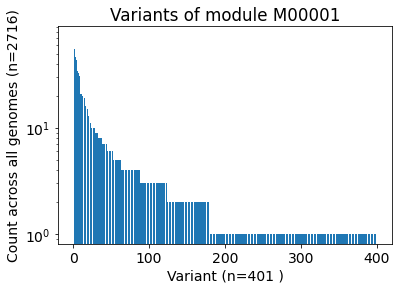

In [17]:
# Histogram showing variants of a given module across genomes in the full dataset
##### not filtered (mod_sets)
mod = 'M00001'
a = list(mod_sets[mod].values())
a.sort(reverse=True)
x_labels = [i for i in range(len(mod_sets[mod].values()))]
plt.bar(x_labels, a)
plt.yscale('log')
plt.title("Variants of module "+mod)
plt.xlabel("Variant (n="+str(len(mod_sets[mod].values()))+" )")
plt.ylabel("Count across all genomes (n="+str(len(tla_to_mod_to_kos))+")")
print(max(mod_sets[mod].values()), len(a))

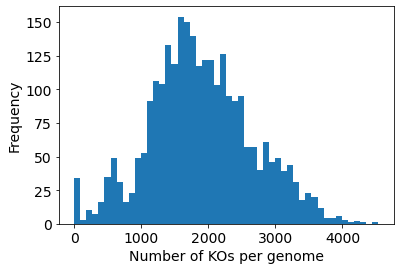

In [18]:
# Plot the number of KOs encoded by each genome in the full dataset
# Note: this includes genomes excluded from the final dataset
plt.hist([len(tnum_to_kos[i]) for i in tnum_to_kos], 50)
plt.xlabel("Number of KOs per genome")
plt.ylabel("Frequency")
plt.savefig(BASE_DIR+"fig.png")

In [19]:
# Median, min, and max # KOs per genome
lens = [len(tnum_to_kos[i]) for i in tnum_to_kos if i in train_genomes or i in test_genomes]
print("Median:",np.median(lens), "Min:",min(lens), "Max:",max(lens))

Median: 1885.0 Min: 528 Max: 4536


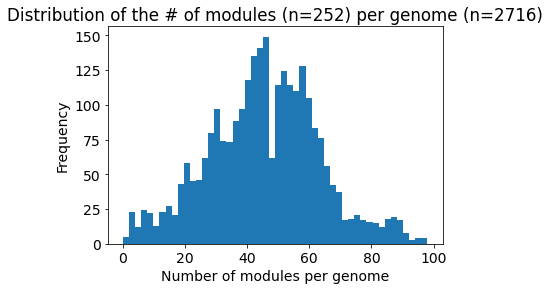

In [20]:
# Plot the number of modules encoded by each genome
fig = data_viz.mods_by_genomes(tla_to_mod_to_kos)

Number of mods encoded in only one genome: 23
Max number of genomes encoding a single mod 2672


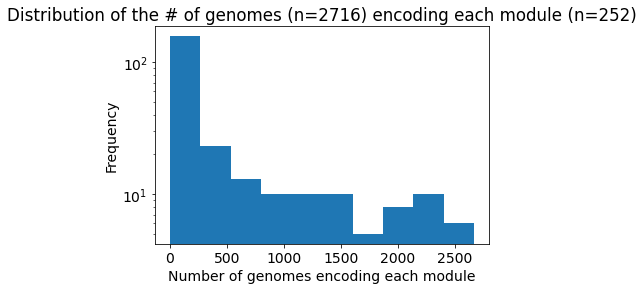

In [21]:
# Count and plot the number of genomes that encode each module
# This is for the whole dataset
mods_count = defaultdict(int)
org_count = 0
for org in tla_to_mod_to_kos:
    for mod in tla_to_mod_to_kos[org]:
        mods_count[mod] += 1
    org_count += 1
        
plt.hist(mods_count.values(), 10)
plt.xlabel("Number of genomes encoding each module")
plt.ylabel("Frequency")
plt.title("Distribution of the # of genomes (n="+str(org_count)+") encoding each module (n="+str(len(mods_count))+")")
plt.yscale('log')
print("Number of mods encoded in only one genome:",list(mods_count.values()).count(1))
print("Max number of genomes encoding a single mod", max(list(mods_count.values())))

In [22]:
# # Plot the percentage of genes per genome that contribute to modules
# perc_mod = []
# for org in tla_to_mod_to_kos:
#     try:
#         tla = tla_to_tnum[org]
#         n_kos = len(tnum_to_kos[tla])
#         n_mod_kos = len([tla_to_mod_to_kos[org][mod] for mod in tla_to_mod_to_kos[org]])
#         perc_mod.append(n_mod_kos/n_kos*100)
#     except: KeyError

# plt.hist(perc_mod, 50)
# plt.xlabel("Percent of KOs contributing to modules")
# plt.ylabel("Frequency")
# plt.title("Distribution of the % of KOs (n_all="+str(n_kos_tot)+") represented by modules (n="+str(n_mods)+") per genome (n="+str(n_genomes)+")")


In [23]:
# # Percentage of KOs that are / are not part of a module

# kos_in_mods = []

# for org in tla_to_mod_to_kos:
#     for mod in tla_to_mod_to_kos[org]:
#         kos_in_mods.extend(tla_to_mod_to_kos[org][mod])

# kos_in_mods = list(set(kos_in_mods))

# print(len(kos_in_mods), len(all_kos), len(kos_in_mods)/len(all_kos)*100)

In [24]:
# # Number of KOs that are part of 1 module, 2 modules, 3 modules, etc
# #all_kos # unique list of all KOs
# ko_counter = defaultdict(list)

# for ko in all_kos:
#     for org in tla_to_mod_to_kos:
#         for mod in tla_to_mod_to_kos[org]:
#             if ko in tla_to_mod_to_kos[org][mod]:
#                 if mod not in ko_counter[ko]:
#                     ko_counter[ko].append(mod)

In [25]:
# ko_counter2 = {}
# for ko in ko_counter:
#     ko_counter2[ko] = len(ko_counter[ko])

# for ko in all_kos:
#     if ko not in ko_counter2:
#         ko_counter2[ko] = 0

In [26]:
# a = defaultdict(int)
# for i in ko_counter2.values():
#     a[i] += 1
# a, sum(a.values())

In [27]:
# plt.hist(ko_counter2.values())
# plt.yscale('log')
# plt.title("Number of modules each KO contributes to")
# plt.xlabel("Number of modules")
# plt.ylabel("Frequency (# of KOs)")

# Corrupt input genomes

In [22]:
# corrupt version 1 -- extreme corruption
# 2020-09-04: select 1-10 mods for input
# 2020-10-16_10mods: select 10 mods for input, genomes with fewer than 10 mods are eliminated
# 2020-10-16_1mods: select 1 mods for input, genomes with fewer than 10 mods are eliminated 

new_corrupt = False
n_corrupt = 100
date_to_save = "2021-01-05_"+str(n_mods)+"mods"
date_to_load = "2021-01-05_10mods"

if new_corrupt:
    print ("Creating new corruptions")
    print (str(n_corrupt),"corruptions per genome")
    print ("With",str(n_mods),"modules as input per genome")
    print ("Saved as",date_to_save)
    #tnum_to_tla = {v:k for k,v in tla_to_tnum.items()}
    corrupted_train, c_train_genomes, train_input_mods = corrupt.corrupt(train_data, train_genomes, n_corrupt, tnum_to_tla, tla_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos, n_mods)
    corrupted_test, c_test_genomes, test_input_mods = corrupt.corrupt(test_data, test_genomes, n_corrupt, tnum_to_tla, tla_to_mod_to_kos, all_kos, mod_to_ko_clean, org_to_kos, n_mods)
    torch.save(corrupted_train, BASE_DIR+"corrupted_train_"+date_to_save+".pt")
    torch.save(c_train_genomes, BASE_DIR+"c_train_genomes_"+date_to_save+".pt")
    torch.save(corrupted_test, BASE_DIR+"corrupted_test_"+date_to_save+".pt")
    torch.save(c_test_genomes, BASE_DIR+"c_test_genomes_"+date_to_save+".pt")
    torch.save(train_input_mods, BASE_DIR+"train_input_mods_"+date_to_save+".pt")
    torch.save(test_input_mods, BASE_DIR+"test_input_mods_"+date_to_save+".pt")
else:
    print("Loading "+date_to_load)
    corrupted_train = torch.load(BASE_DIR+"corrupted_train_"+date_to_load+".pt")
    c_train_genomes = torch.load(BASE_DIR+"c_train_genomes_"+date_to_load+".pt")
    corrupted_test = torch.load(BASE_DIR+"corrupted_test_"+date_to_load+".pt")
    c_test_genomes = torch.load(BASE_DIR+"c_test_genomes_"+date_to_load+".pt")
    train_input_mods = torch.load(BASE_DIR+"train_input_mods_"+date_to_load+".pt")
    test_input_mods = torch.load(BASE_DIR+"test_input_mods_"+date_to_load+".pt")
    
print ("done")

Loading 2021-01-05_10mods
done


In [23]:
# confirm that there are no all-zero rows
non_zero_idx = corrupted_train.sum(axis=1) > n_min
len(non_zero_idx), corrupted_train.shape[0]

(230500, 230500)

In [24]:
corrupted_train.shape, corrupted_test.shape

(torch.Size([230500, 19726]), torch.Size([27900, 19726]))

# Visualization of final datasets

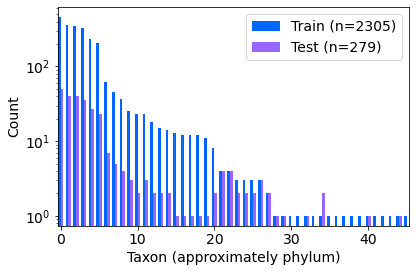

In [25]:
fig, labels, y3 = data_viz.plot_tax_dist(c_train_genomes, c_test_genomes, 'Desktop')
#plt.savefig(BASE_DIR+"fig_dist.png", bbox_inches='tight')

In [26]:
def get_lengths(c_genomes, tnum_to_kos):
    lens = []
    for i in list(set(c_genomes)):
        tnum = tla_to_tnum[i]
        lens.append(len(tnum_to_kos[tnum]))
    return lens

train_lens = get_lengths(c_train_genomes, tnum_to_kos)
test_lens = get_lengths(c_test_genomes, tnum_to_kos)

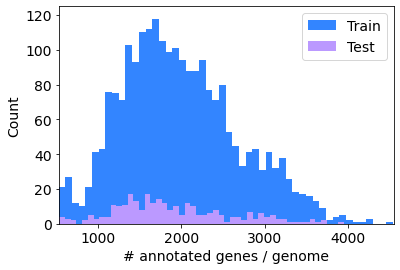

In [27]:
# Plot the number of KOs encoded by each genome
fig, ax = plt.subplots()
plt.hist(train_lens, 50, color='#3385ff')
plt.hist(test_lens, 50, color='#bb99ff')
ax.legend(['Train', 'Test'])
plt.xlabel("# annotated genes / genome")
plt.ylabel("Count")
plt.ylim(0,125)
plt.xlim(min(train_lens),max(train_lens)+10)
#plt.savefig(BASE_DIR+"fig_ko_dist.pdf", figsize=(370.336, 245.416), bbox_inches='tight')

Text(0, 0.5, 'Number of genomes')

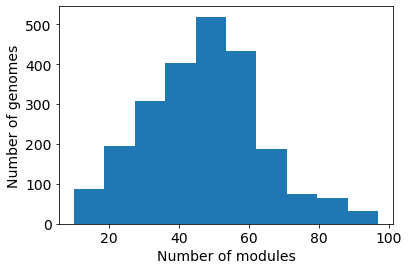

In [28]:
# How many modules are there per training genome?
from collections import defaultdict
mods_count = defaultdict(int)
for org in tla_to_mod_to_kos:
    if org in c_train_genomes:
        mods_count[org] = len(tla_to_mod_to_kos[org])
plt.hist(mods_count.values())
plt.xlabel('Number of modules')
plt.ylabel('Number of genomes')

# HPO w/ Ray Tune: Define and train network

In [ ]:
memory = 2000 * 1024 * 1024
object_store_memory = 200 * 1024 * 1024
driver_object_store_memory=100 * 1024 * 1024
ray.shutdown()
ray.init(local_mode=True, memory=memory, 
        object_store_memory=object_store_memory,
        driver_object_store_memory=driver_object_store_memory,
        num_cpus=10)

In [ ]:
config = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": 0.5,
         "nn_layers": tune.choice([1, 2, 3, 4]),
         "batch_size": tune.choice([32, 64, 128, 256]),
          "lr": tune.loguniform(1e-4, 1e-1), 
          "weight_decay": tune.loguniform(1e-5, 1e-2) 
         }

In [ ]:
config_corruption = {"num_epochs": 10,
         "kfolds": 10,
         "replacement_threshold": 0.5,
         "nn_layers": 3,
         "batch_size": 128,
          "lr": 0.001, 
          "weight_decay": 0.1
         }

In [ ]:
analysis = tune.run(
    trainable.train_AE, 
    name="17_02_2021_40mods",
    config=config_corruption,
    verbose=2, 
    resources_per_trial={
            "cpu": 10,
            "gpu": 0
    },
    #num_samples=20,
    num_samples=1,
    queue_trials=True,
    local_dir="/Users/natasha/Desktop/TUNE_RESULT_DIR",
    #local_dir="/home/ndudek/projects/def-dprecup/ndudek/hp_tuning_01-10-2020/TUNE_RESULT_DIR"
    )

In [ ]:
# print("Best config is:", analysis.get_best_config(metric="test_f1"))

In [ ]:
# analysis.get_best_config(metric="test_f1")

# Single model: Define and train network

In [ ]:
# nn_layers = 3
# weight_decay = 0.1
# lr = 0.001
# batch_size = 128
# kfolds = 10
# num_epochs = 10
# replacement_threshold = 0.5

# kld0, bce0, train_losses, test_losses, train_f1s, test_f1s, model = trainable.train_single_vae(nn_layers, weight_decay, lr, batch_size, kfolds, num_epochs, replacement_threshold, corrupted_train, corrupted_test)


In [ ]:
# version = "0mod"
# torch.save(model.state_dict(), BASE_DIR+"_"+version+"_model.pt")

# torch.save(train_losses, BASE_DIR+"_"+version+"_train_losses.pt")
# torch.save(test_losses, BASE_DIR+"_"+version+"_test_losses.pt")
# torch.save(bce0, BASE_DIR+"_"+version+"_bce0.pt")
# torch.save(kld0, BASE_DIR+"_"+version+"_kld0.pt")
# torch.save(train_f1s, BASE_DIR+"_"+version+"_train_f1s.pt")
# torch.save(test_f1s, BASE_DIR+"_"+version+"_test_f1s.pt")

In [31]:
load_model = True
version = "10mod"
if load_model:
    from genome_embeddings import models
    n_features = int(corrupted_train.shape[1]/2)
    model = models.VariationalAutoEncoder(n_features, 3)
    model.load_state_dict(torch.load(BASE_DIR+"_"+version+"_model.pt"))
    train_losses = torch.load(BASE_DIR+"_"+version+"_train_losses.pt")
    test_losses = torch.load(BASE_DIR+"_"+version+"_test_losses.pt")
    train_f1s = torch.load(BASE_DIR+"_"+version+"_train_f1s.pt")
    test_f1s = torch.load(BASE_DIR+"_"+version+"_test_f1s.pt")
    bce0 = torch.load(BASE_DIR+"_"+version+"_bce0.pt")
    kld0 = torch.load(BASE_DIR+"_"+version+"_kld0.pt")

# Evaluate model performance

### Generate predictions on test set

In [32]:
# 1-10 modules per input genome: 0.74
# 1 module per input genome: 0.64
# 10 modules per input genome: 0.81
n_features = int(corrupted_test.shape[1]/2)
corrupted = corrupted_test[:,:n_features]
uncorrupted = corrupted_test[:,n_features:]

In [33]:
new_preds = False

model.eval()

if new_preds:
    with torch.no_grad():
        pred = model.forward(corrupted)[0].detach()
    binary_pred = evaluate.eval_binarize(pred, 0.5)
    torch.save(pred, BASE_DIR+"_preds.pt")
    torch.save(binary_pred, BASE_DIR+"_binary_preds.pt")
else:
    pred = torch.load(BASE_DIR+"_preds.pt")
    binary_pred = torch.load(BASE_DIR+"_binary_preds.pt")

### Investigate test set F1 score (micro-average) and calculate TNs, FPs, FNs, TPs

In [34]:
f1 = sk.metrics.f1_score(uncorrupted, binary_pred, zero_division=0, average='micro')
print("Test set F1 score",f1)

Test set F1 score 0.8184021622829981


median F1 score: 0.8278844178548066 min 0.38784881667255383 max 0.990092879256966


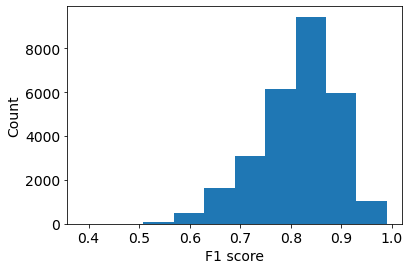

In [35]:
f1s, fig = evaluate.test_f1s(uncorrupted, binary_pred)
plt.savefig(BASE_DIR+"f1_dist.pdf", bbox_inches='tight')

In [36]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, binary_pred)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


82.92 2.34 2.91 11.83


In [37]:
tns[0]

7614

### Examine at BCE vs KLD loss

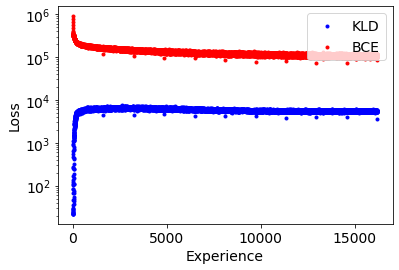

In [38]:
# Plot BCE and KLD vs experience
data_viz.kld_vs_bce(kld0,bce0)

### Plot learning curves

max F1 score 0.8831515404956504


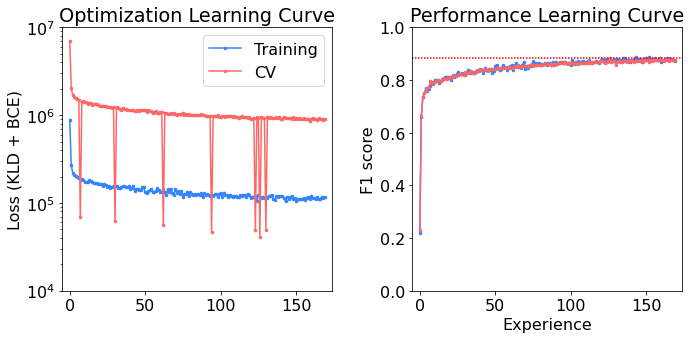

In [39]:
plt.rcParams.update({'font.size': 12})
fig = data_viz.learning_curve(train_losses, test_losses, train_f1s, test_f1s)
#plt.savefig(BASE_DIR+"learning_curves.pdf", bbox_inches='tight')

### Plot ROC curve and generate AUC score (micro-average)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


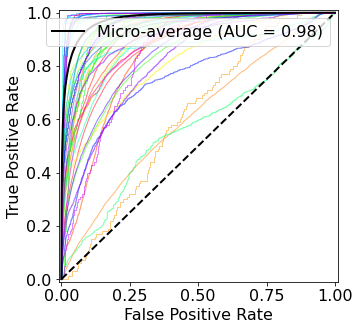

In [40]:
num_features = int(corrupted_test.shape[1]/2)
true_genomes = corrupted_test[:,num_features:]
fig = data_viz.my_roc_curve(true_genomes.numpy(), pred.numpy())
#fig.savefig(BASE_DIR+"roc_fig.pdf", dpi=200, bbox_inches='tight')

max F1 score 0.8831515404956504


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:800: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


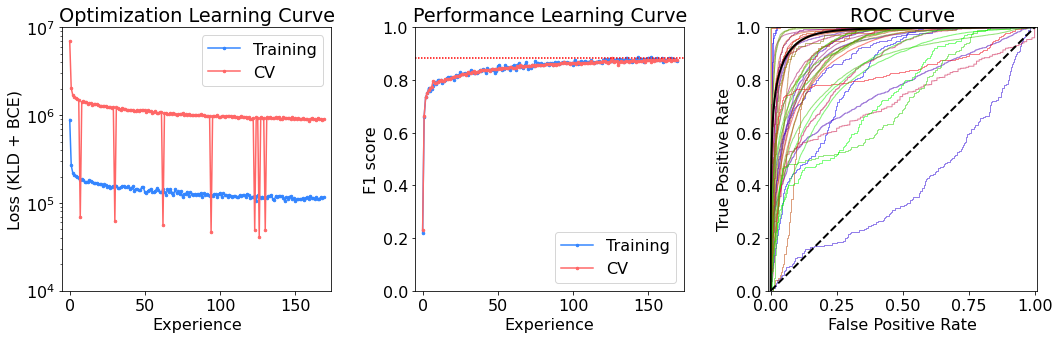

In [86]:
fig = data_viz.learningNroc_curve(train_losses, test_losses, train_f1s, 
                                  test_f1s, true_genomes.numpy(), pred.numpy())


In [42]:
#fig.savefig(BASE_DIR+"LCroc_fig.pdf", dpi=200, bbox_inches='tight')

### Are the input genes present in the output?

There are 6675 instance of inputs being 100% present in output
This is out of 27900 instances or 23.92% of cases
There are 23774 instance of inputs being >=90% present in output (85.21%)


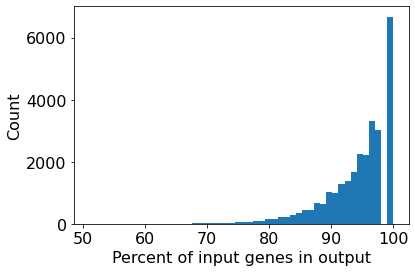

In [43]:
# relabel y axis by % rather than count
fig, _ = evaluate.compare_in_n_out(binary_pred, corrupted)
#fig.savefig(BASE_DIR+"input_vs_output.pdf", bbox_inches='tight', dpi=200)

### What are the best and worst performing instances?

In [44]:
# babt = Brucella abortus
idx_best = f1s.index(max(f1s))
tla_best = c_test_genomes[idx_best]
idx_best, tla_best, f1s[idx_best], tla_to_tnum[tla_best]

(3684, 'babt', 0.990092879256966, 'T03461')

In [45]:
# Get index of median F1 score
f1s_sorted = sorted(f1s, reverse=True)
idx_median = f1s.index(f1s_sorted[int(len(f1s_sorted)/2)])
tla_median = c_test_genomes[idx_median]
idx_median, tla_median, f1s[idx_median], tla_to_tnum[tla_median]

(8224, 'dru', 0.8278835788717211, 'T01518')

In [46]:
# nmv = Nitrospira moscoviensis
# seny = Pectobacteriaceae sodalis (Gammaprot), endosymbiont of Henestaris halophilus
# bmx
idx_worst = f1s.index(min(f1s))
tla_worst = c_test_genomes[idx_worst]
idx_worst, tla_worst, f1s[idx_worst], tla_to_tnum[tla_worst]

(21754, 'seny', 0.38784881667255383, 'T05311')

### For the best scoring instance, plot pixel diagram

Uncorrupted -- On: 1608 Off: 8255
Uncorrupted -- On: 54 Off: 9809
Generated -- TN: 8232 FP: 23 FN: 9 TP: 1599
0.990092879256966
9863
n_features 9863 len(colour_pred) 9863 n_extension 37
9900


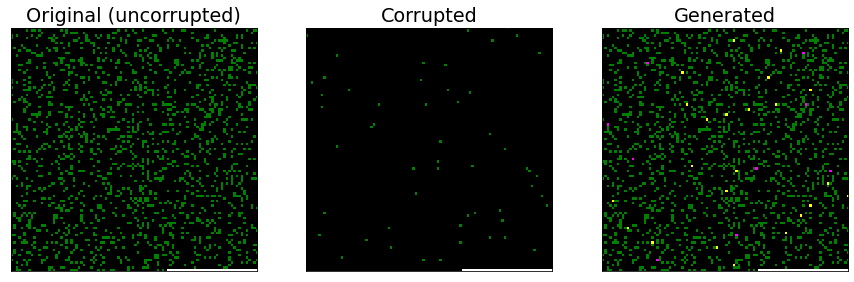

In [47]:
idx = idx_best
fig = data_viz.genome_heatmap2(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4.pdf", bbox_inches='tight', dpi=200)

In [48]:
print("Num genes on in uncorrupted idx_best genome", torch.sum(uncorrupted[idx_best,:]))
print("Num genes off in uncorrupted idx_best genome", n_features - torch.sum(uncorrupted[idx_best,:]))
print("Num genes on in corrupted idx_best genome", torch.sum(corrupted[idx_best,:]))

Num genes on in uncorrupted idx_best genome tensor(1608.)
Num genes off in uncorrupted idx_best genome tensor(8255.)
Num genes on in corrupted idx_best genome tensor(54.)


labels ['TN', 'TP', 'FN', 'FP']
babt F1: 0.990092879256966
generated genome: [1599, 8232, 9, 23]
generated genome: [16.21, 83.46, 0.09, 0.23]



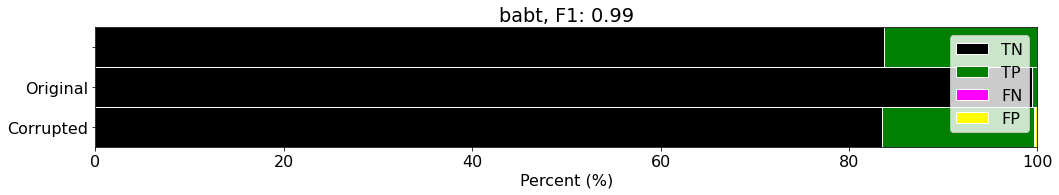

In [49]:
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted, idx_best)
fig.savefig(BASE_DIR+"barh.pdf", bbox_inches='tight', dpi=200)

In [50]:
# get genes, pathways of FPs and FNs

# identify which genes are FPs or FNs
uncorrupted_one = uncorrupted[idx_best] 
pred_one = binary_pred[idx_best]

fp_idxs = [] # list of KOs which are FPs in pred
fn_idxs = []
for i in range(len(uncorrupted_one)):
    if uncorrupted_one[i] == 1 and pred_one[i] == 0: # FN
        fn_idxs.append(all_kos[i])
    if uncorrupted_one[i] == 0 and pred_one[i] == 1: # FP
        fp_idxs.append(all_kos[i])

In [52]:
mod_prescence = defaultdict(list)
for mod in mod_to_ko_clean:
    for ko in fn_idxs:
        if ko in mod_to_ko_clean[mod]:
            mod_prescence[mod].append(ko)

In [53]:
mod_prescence

defaultdict(list, {'M00027': ['K01580']})

False negatives:
K12368 -- autotransporter family porin -- transporter
K09016 -- putative pyrimidine permease RutG -- transporter
K12678 -- autotransporter family porin -- transporter
K01580 -- glutamate decarboxylase
K00449 -- protocatechuate 3,4-dioxygenase, beta subunit -- degradation of aromatic compounds (e.g.: terephthalate)
K02395 -- peptidoglycan hydrolase FlgJ -- flagellar assembly
K05802 -- potassium-dependent mechanosensitive channel -- transporter
K02480 -- two-component system, NarL family, sensor kinase -- Two-component system
K08219 -- MFS transporter, UMF2 family, putative MFS family transporter protein -- transporter

Five out of nine lost genes are transporters

False positives:
K13926 -- ribosome-dependent ATPase
K02029 -- polar amino acid transport system permease protein
K16695 -- lipopolysaccharide exporter
K00978 -- glucose-1-phosphate cytidylyltransferase
K18979 -- epoxyqueuosine reductase
K17315 -- glucose/mannose transport system substrate-binding protein
K01710 -- dTDP-glucose 4,6-dehydratase -- dTDP-L-rhamnose biosynthesis
K02377 -- GDP-L-fucose synthase
K07733 -- prophage regulatory protein
K06938 -- uncharacterized protein
K07344 -- type IV secretion system protein TrbL -- quorum sensing
K20266 -- type IV secretion system protein TrbJ -- quorum sensing
K02851 -- UDP-GlcNAc:undecaprenyl-phosphate/decaprenyl-phosphate GlcNAc-1-phosphate transferase
K02410 -- flagellar motor switch protein FliG
K08224 -- MFS transporter, YNFM family, putative membrane transport protein
K02914 -- large subunit ribosomal protein L34
K03457 -- nucleobase:cation symporter-1, NCS1 family
K03313 -- Na+:H+ antiporter, NhaA family
K01790 -- dTDP-4-dehydrorhamnose 3,5-epimerase -- dTDP-L-rhamnose biosynthesis
K07473 -- DNA-damage-inducible protein J
K03208 -- colanic acid biosynthesis glycosyl transferase WcaI
K03818 -- putative colanic acid biosynthesis acetyltransferase WcaF
K08319 -- L-threonate 2-dehydrogenase

In [54]:
# These should probably be saved and loaded at start // moved to "build dataset"
tnum_to_taxid, tnum_to_tax = pre_process.get_tax()

In [55]:
tnum_best = tla_to_tnum[tla_best]
genus_best = tnum_to_tax[tnum_best][5]
tnum_best, genus_best

('T03461', 'Brucella')

In [56]:
index_now = idx_best
tla_now = c_test_genomes[index_now]
tnum_now = tla_to_tnum[tla_now]

In [57]:
ten_df, closest_genomes = evaluate.get_ten_closest(index_now, tnum_now, test_genomes, 
                                  train_genomes, test_data, train_data, binary_pred, 
                                 tnum_to_tax)

/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:620: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


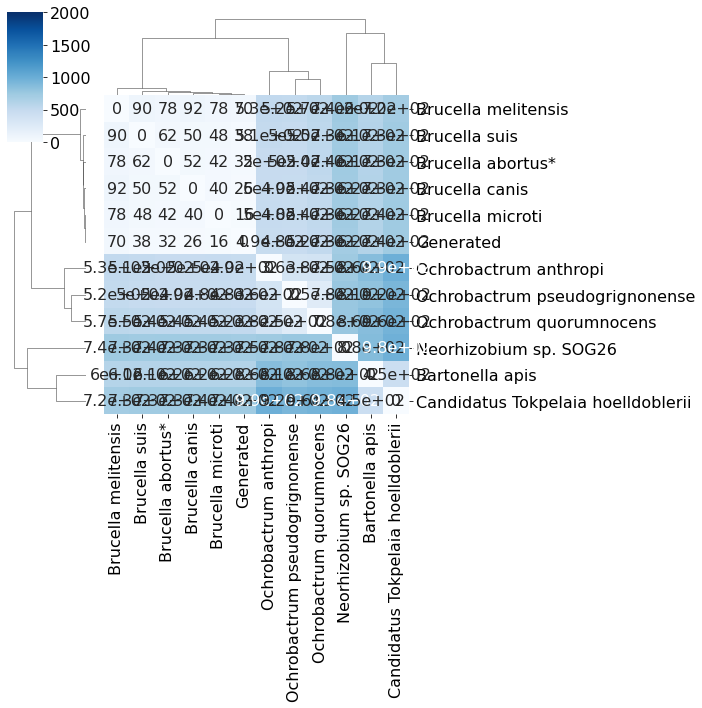

In [58]:
fig = evaluate.diff_heatmap(ten_df)
fig.savefig(BASE_DIR+"best_heatmap.pdf", bbox_inches='tight', dpi=200)

/usr/local/lib/python3.7/site-packages/matplotlib_venn/_venn3.py:117: UserWarning: Bad circle positioning
  warnings.warn("Bad circle positioning")


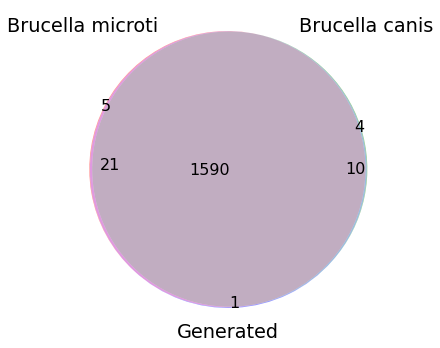

In [59]:
genome1 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][0]
genome2 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][1]

fig, ax = evaluate.compare_venn(genome1, genome2, 'Generated', ten_df)
ax.figure.savefig(BASE_DIR+"best_venn.pdf", bbox_inches='tight', dpi=200)

There are 521 genomes in the training set that have all ten mods


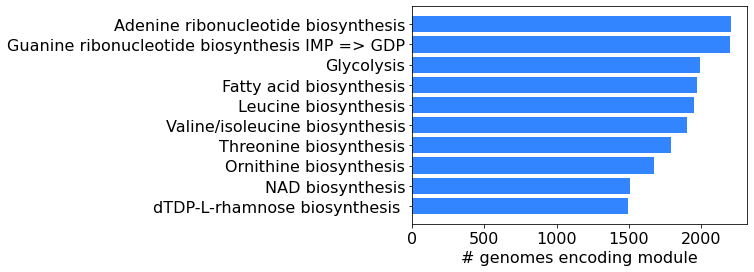

In [68]:
mod_names = evaluate.map_proc_mod()
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, org_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print("There are",len(all_ten),"genomes in the training set that have all ten mods")

In [69]:
# Plot test F1 score vs # shared input mods

In [70]:
len(c_test_genomes), len(f1s), len(test_input_mods)

(27900, 27900, 27900)

In [71]:
num_mods = []
for i, tla in enumerate(c_test_genomes):
        
    # which mods were used as input to this genome
    gen_mods = test_input_mods[i]
    
    # Which orgs have those mods?
    all_ten = []
    for tla_compare in org_to_mod_to_kos:
        try:
            tnum = tla_to_tnum[tla_compare]
        except KeyError: pass
        if tnum not in train_genomes: continue
        if tla == tla_compare: continue
            
        # of input mods, how many genomes have all ten?
        mods = list(org_to_mod_to_kos[tla_compare].keys())
        all_present = True
        for s in gen_mods:
            if s not in mods: all_present = False
        if all_present:
            all_ten.append(tnum)
            
    num_mods.append(len(all_ten))

In [72]:
min(num_mods), max(num_mods), np.median(num_mods)

(0, 1174, 35.0)

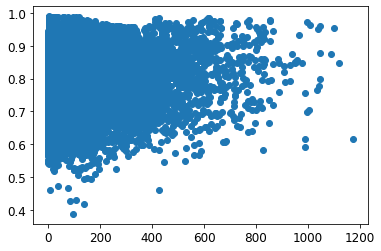

In [165]:
fig, ax = plt.subplots()
fig = ax.scatter(num_mods, f1s)
fig

In [161]:
plt.savefig(BASE_DIR+'numMods_vs_F1.pdf', dpi=200)
plt.savefig(BASE_DIR+'numMods_vs_F1.png', dpi=200)

<Figure size 432x288 with 0 Axes>

In [74]:
# F1 score vs phylogenetic relatedness
tax_groups = {'phylum': [],
             'class': [],
             'order': [],
             'family': [],
             'genus': [],
             'species': []} # taxonomic groups in training set

for tnum in tnum_to_tax:
    if tnum in train_genomes:
        tax_groups['phylum'].append(tnum_to_tax[tnum][1])
        tax_groups['class'].append(tnum_to_tax[tnum][2])
        tax_groups['order'].append(tnum_to_tax[tnum][3])
        tax_groups['family'].append(tnum_to_tax[tnum][4])
        tax_groups['genus'].append(tnum_to_tax[tnum][5])
        tax_groups['species'].append(tnum_to_tax[tnum][6])

# for i in tax_groups:
#     tax_groups[i] = list(set(tax_groups[i]))

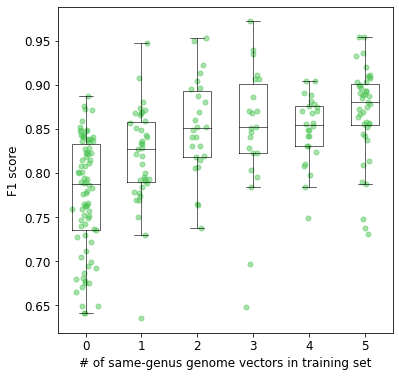

In [128]:
fig, groups = evaluate.genus_boxplot(c_test_genomes, tla_to_tnum, 
                                     tnum_to_tax, tax_groups, f1s)

In [96]:
#fig.savefig(BASE_DIR+"genus_boxplot.pdf", bbox_inches='tight', dpi=200)

In [88]:
anova, tukey = evaluate.genus_boxplot_stats(groups)

In [91]:
anova

,Source,ddof1,ddof2,F,p-unc,np2
0,group,5,232,19.161412,5.984021e-16,0.292267


In [92]:
print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   0.0    1.0   0.0438 0.0021  0.0111 0.0765   True
   0.0    2.0   0.0761  0.001  0.0383  0.114   True
   0.0    3.0    0.072  0.001  0.0316 0.1123   True
   0.0    4.0   0.0734  0.001  0.0355 0.1112   True
   0.0    5.0   0.0934  0.001  0.0617  0.125   True
   1.0    2.0   0.0323 0.2504 -0.0103 0.0749  False
   1.0    3.0   0.0281 0.4663 -0.0167  0.073  False
   1.0    4.0   0.0295 0.3492  -0.013 0.0721  False
   1.0    5.0   0.0495 0.0023  0.0124 0.0867   True
   2.0    3.0  -0.0042    0.9 -0.0529 0.0445  False
   2.0    4.0  -0.0028    0.9 -0.0494 0.0439  False
   2.0    5.0   0.0172 0.8232 -0.0245  0.059  False
   3.0    4.0   0.0014    0.9 -0.0473 0.0501  False
   3.0    5.0   0.0214  0.703 -0.0227 0.0655  False
   4.0    5.0     0.02 0.7138 -0.0218 0.0618  False
---------------------------------------------------


### For median scoring instance, plot pixel diagram

In [ ]:
idx = idx_median
fig = data_viz.genome_heatmap2(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4_median.pdf", bbox_inches='tight', dpi=200)

In [ ]:
print("Num genes on in uncorrupted idx_best genome", torch.sum(uncorrupted[idx_median,:]))
print("Num genes off in uncorrupted idx_best genome", n_features - torch.sum(uncorrupted[idx_median,:]))
print("Num genes on in corrupted idx_best genome", torch.sum(corrupted[idx_median,:]))

In [ ]:
print(8232/9863*100) # TN
print(1152/9863*100) # TP
print(376/9863*100) # FN
print(103/9863*100) # FP

In [ ]:
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted, idx_median)
fig.savefig(BASE_DIR+"barh_median.pdf", bbox_inches='tight', dpi=200)

In [ ]:
index_now = idx_median
tla_now = c_test_genomes[index_now]
tnum_now = tla_to_tnum[tla_now]

In [ ]:
ten_df, closest_genomes = evaluate.get_ten_closest(index_now, tnum_now, test_genomes, 
                                  train_genomes, test_data, train_data, binary_pred, 
                                 tnum_to_tax)

In [ ]:
fig = evaluate.diff_heatmap(ten_df)
fig.savefig(BASE_DIR+"median_heatmap.pdf", bbox_inches='tight', dpi=200)

In [ ]:
genome1 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][0]
genome2 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][1]
fig, ax = evaluate.compare_venn(genome1, genome2, 'Generated', ten_df)
ax.figure.savefig(BASE_DIR+"median_venn.pdf", bbox_inches='tight', dpi=200)

In [ ]:
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, org_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print(len(all_ten))   

### For the worst scoring instance, plot pixel diagram

In [ ]:
idx = idx_worst
fig = data_viz.genome_heatmap2(corrupted_test, idx, model, f1s, tns, fps, fns, tps, binary_pred)
fig.savefig(BASE_DIR+"fig4_worst.pdf", bbox_inches='tight', dpi=200)

In [ ]:
# print median TNs, FPs, FNs, TPs
np.median(tns), np.median(fps), np.median(fns), np.median(tps)

In [ ]:
fig = evaluate.snowplot(f1s, c_test_genomes, tns, fps, fns, tps, uncorrupted, corrupted, idx_worst)
fig.savefig(BASE_DIR+"barh_worst.pdf", bbox_inches='tight', dpi=200)

In [ ]:
index_now = idx_worst
tla_now = c_test_genomes[index_now]
tnum_now = tla_to_tnum[tla_now]

In [ ]:
ten_df, closest_genomes = evaluate.get_ten_closest(index_now, tnum_now, test_genomes, 
                                  train_genomes, test_data, train_data, binary_pred, 
                                 tnum_to_tax)

In [ ]:
fig = evaluate.diff_heatmap(ten_df)
fig.savefig(BASE_DIR+"worst_heatmap.pdf", bbox_inches='tight', dpi=200)

In [ ]:
genome1 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][0]
genome2 = [tnum_to_tax[i][6] for i in closest_genomes[:2]][1]

fig, ax = evaluate.compare_venn(genome1, genome2, 'Generated', ten_df)
ax.figure.savefig(BASE_DIR+"worst_venn.pdf", bbox_inches='tight', dpi=200)

In [ ]:
fig, all_ten = evaluate.compare_inputs(test_input_mods, index_now, org_to_mod_to_kos, 
                                       train_genomes, tla_to_tnum, mod_names)
print(len(all_ten))        

### How does the model perform on inputs originating from different phyla

In [104]:
# get dicts to map genome tla back to list of phylum, class, etc
train_tax_dict, test_tax_dict = data_viz.tax_distribution(c_train_genomes, c_test_genomes, 'Desktop')

In [105]:
count_per_phy = defaultdict(int)
for tnum in test_genomes:
    tla = tnum_to_tla[tnum]
    phylum = test_tax_dict[tla][1]
    if phylum == 'Proteobacteria':
        phylum = test_tax_dict[tla][2]
    count_per_phy[phylum] += 1
count_per_phy

defaultdict(int,
            {'Betaproteobacteria': 23,
             'Actinobacteria': 36,
             'Gammaproteobacteria': 50,
             'Alphaproteobacteria': 40,
             'Firmicutes': 40,
             'Tenericutes': 2,
             'Synergistetes': 2,
             'Deltaproteobacteria': 7,
             'Acidithiobacillia': 2,
             'Bacteroidetes': 27,
             'Thermotogae': 2,
             'Oligoflexia': 4,
             'Verrucomicrobia': 1,
             'Epsilonproteobacteria': 4,
             'Chloroflexi': 2,
             'Armatimonadetes': 1,
             'Chlorobi': 1,
             'Thermodesulfobacteria': 3,
             'Dictyoglomi': 1,
             'Elusimicrobia': 2,
             'Fusobacteria': 2,
             'Deferribacteres': 2,
             'Gemmatimonadetes': 2,
             'Ignavibacteriae': 1,
             'Planctomycetes': 3,
             'Nitrospirae': 4,
             'Zetaproteobacteria': 1,
             'Spirochaetes': 3,
             '

In [106]:
train_phyla, test_phyla = evaluate.f1s_per_phylum(train_tax_dict, test_tax_dict, c_test_genomes, f1s)

In [107]:
# number of phyla in train + test sets
len(set(list(train_phyla.keys()) + list(test_phyla.keys())))

46

Best: Chlorobi 0.9108061749571184
Worst: Acidobacteria 0.6408560843996653


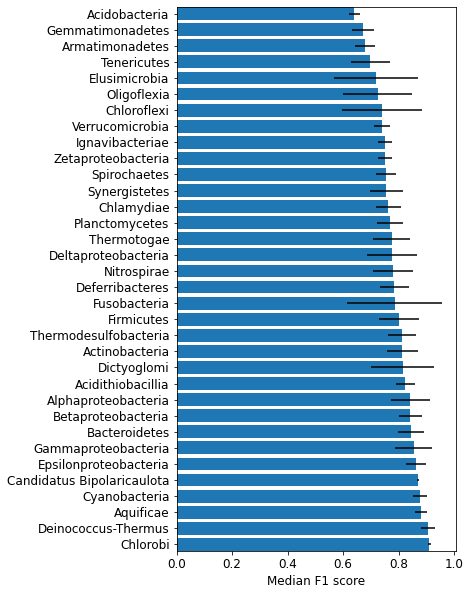

In [108]:
# Bars represent median absolute deviation
fig_save_for_later = evaluate.plot_f1_per_phylum(test_phyla, (5,10))
fig_save_for_later.savefig(BASE_DIR+"f1_per_phylum.png", dpi=200, bbox_inches='tight')

In [109]:
# Are the results between phyla statistically significant?
stats.kruskal(*test_phyla.values())

KruskalResult(statistic=5338.587693743908, pvalue=0.0)

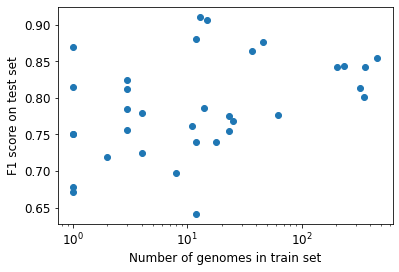

In [110]:
fig = evaluate.plot_count_vs_f1s(train_phyla, test_phyla)

There appears to be an effect of number of training genomes / phylum on test set per phylum F1 score 

### How many times is each mod used in the various corrupted inputs?

In [111]:
# Number of times each mod occurs in the training set corrupted genomes
train_out = evaluate.train_out(train_input_mods)

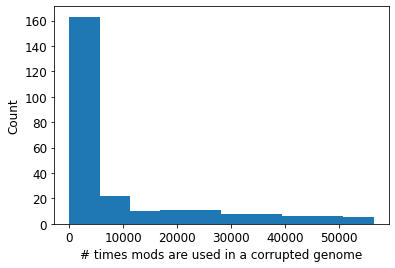

In [112]:
fig = evaluate.plot_train_count_hist(train_out)

### How does genome size correlate with F1 score

In [113]:
# x-axis = # genes in input genome
# y-axis = F1 score of reconstructed genomes

In [114]:
n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row

Text(0, 0.5, 'F1 score')

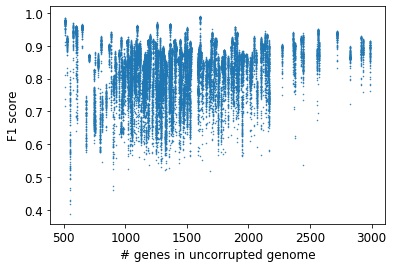

In [115]:
plt.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in uncorrupted genome")
plt.ylabel("F1 score")

In [116]:
n_genes_corrupted = torch.sum(corrupted, 1).numpy().tolist() # get sum of each row

Text(0, 0.5, 'F1 score')

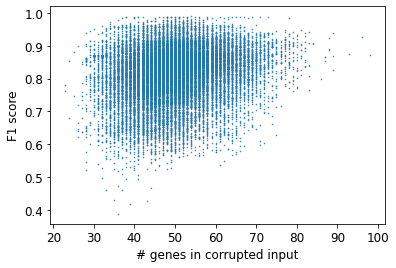

In [117]:
plt.scatter(n_genes_corrupted, f1s, marker='.', s = 1)
plt.xlabel("# genes in corrupted input")
plt.ylabel("F1 score")

### How much variance is there in the F1 score of genomes encoding certain modules?
Do some modules / lifestyles get reconstructed better than others?

In [120]:
process_to_mod, mod_to_proc = evaluate.map_proc_mod1()

In [ ]:
#fig, done = evaluate.plot_mod_count_vs_f1(test_input_mods, c_test_genomes, train_input_mods, f1s)

In [ ]:
#fig = evaluate.plot_mod_vs_f1(test_input_mods, f1s)

In [ ]:
# Plot whether number of modules in process correlates with F1 score
# More interchangeable options = worse performance?

In [121]:
subprocess_to_mod, mod_to_subproc = evaluate.map_subproc_mod()

In [ ]:
# fig = evaluate.plot_metab_pathway_f1(subprocess_to_mod, test_input_mods, f1s)

### Analyze F1 scores of actual KOs

In [122]:
### THIS MUST BE USED IN MULTIPLE PLACES
ko_f1s = []
for i in range(uncorrupted.shape[1]): # for every column
    f1 = sk.metrics.f1_score(uncorrupted[:,i], binary_pred[:,i], zero_division=0)
    ko_f1s.append(f1)

In [123]:
zeros = 0
for i in ko_f1s:
    if i == 0:
        zeros += 1
print(zeros, len(ko_f1s), zeros/len(ko_f1s)*100)

2202 9863 22.32586434147825


In [124]:
# In the training set, how many KOs are always zero?
zeros_train = train_data.sum(axis=0) > 0
n_ones = np.sum(zeros_train)
n_zeros_train = len(zeros_train) - n_ones
print("There are",n_zeros_train,"genes that are always off in the training set")

There are 77 genes that are always off in the training set


Text(0, 0.5, 'Count')

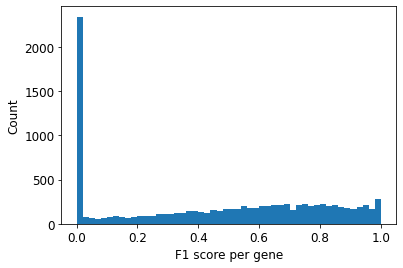

In [125]:
fig = plt.figure()
plt.hist(ko_f1s, bins = 50)
plt.xlabel("F1 score per gene")
plt.ylabel("Count")

max KO count: 230300 , total number of training genomes: 230500


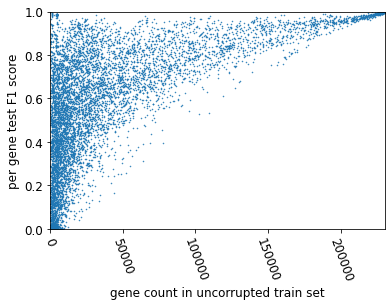

In [126]:
# gene occurence in uncorrupted ds vs F1 score
#ko_counts = torch.sum(uncorrupted, 0)
# get gene occurence in uncorrupted training set
tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)

fig, ax = plt.subplots()
plt.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax.set_xlim(0, tr_uncorrupted.shape[0])
ax.set_ylim(0,1)
plt.xlabel("gene count in uncorrupted train set")
plt.ylabel("per gene test F1 score")
plt.xticks(rotation=-70)
print("max KO count:",int(max(ko_counts)), ", total number of training genomes:",tr_uncorrupted.shape[0])

### Generate figure for paper

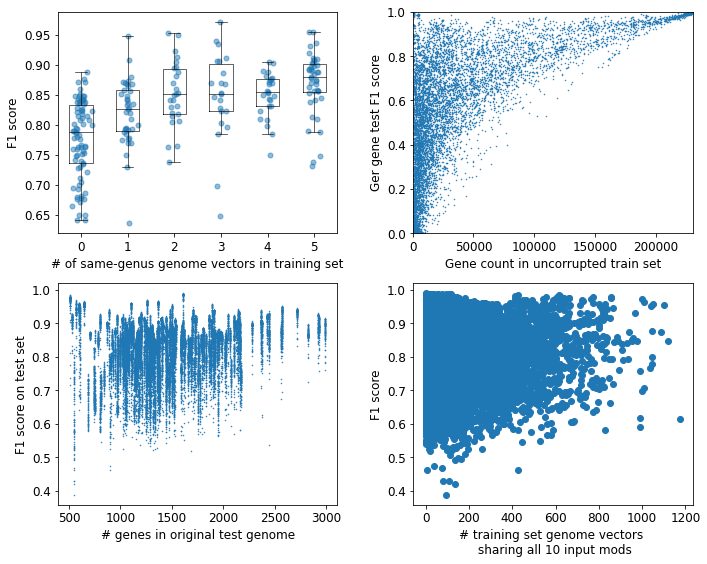

In [177]:
#import pylab as P

fig, axs = plt.subplots(2,2, figsize=(10, 8))

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

# phylum_f1s = [np.median(test_phyla[i]) for i in test_phyla]
# phylum_count = [train_phyla[i] for i in test_phyla]
# ax1.scatter(phylum_count, phylum_f1s)
# ax1.set_xlabel("Number of genomes in train set")
# ax1.set_ylabel("F1 score on test set")
# ax1.set_xscale('log')


### PANEL A
groups = evaluate.genus_boxplot_partial(c_test_genomes, tla_to_tnum, 
                                     tnum_to_tax, tax_groups, f1s)
for i, group in enumerate(groups):
    x = np.random.normal(1+i, 0.08, size=len(group)) # scatter
    ax1.plot(x, group, color='#1f77b4', marker='.', linestyle="None", alpha=0.5, markersize = 10) 

bp = ax1.boxplot(groups, labels=[0,1,2,3,4,5], sym='.', showfliers=False) 
ax1.set_xlabel('# of same-genus genome vectors in training set')
ax1.set_ylabel('F1 score')
# Change outline color, fill color and linewidth of the boxes
for box in bp['boxes']:
    # Change outline color
    box.set( color='#000000', linewidth=0.6, linestyle='-')

# Change linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#000000', linewidth=0.6, linestyle='-')

# Change color and linewidth of the caps
for cap in bp['caps']:
    cap.set(color='#000000', linewidth=0.6)

# Change color and linewidth of the medians
for median in bp['medians']:
    median.set(color='#000000', linewidth=0.6)

### PANEL B
tr_uncorrupted = corrupted_train[:,n_features:]
ko_counts = torch.sum(tr_uncorrupted, 0)
ax2.scatter(ko_counts, ko_f1s, marker='.', s = 1)
ax2.set_xlim(0, tr_uncorrupted.shape[0])
ax2.set_ylim(0,1)
ax2.set_xlabel("Gene count in uncorrupted train set")
ax2.set_ylabel("Ger gene test F1 score")

### PANEL C
n_genes_uncorrupted = torch.sum(uncorrupted, 1).numpy().tolist() # get sum of each row
ax3.scatter(n_genes_uncorrupted, f1s, marker='.', s = 1)
ax3.set_xlabel("# genes in original test genome")
ax3.set_ylabel("F1 score on test set")

### PANEL D
ax4.scatter(num_mods, f1s)
ax4.set_xlabel("# training set genome vectors \n sharing all 10 input mods")
ax4.set_ylabel("F1 score")

plt.tight_layout()

In [178]:
fig.savefig(BASE_DIR+"bio_insights_contd.pdf", dpi=200, bbox_inches='tight')
fig.savefig(BASE_DIR+"bio_insights_contd.png", dpi=400, bbox_inches='tight')

In [ ]:
# F1 score on KOs + what metab pathway they are part of

In [ ]:
fig = evaluate.plot_metab_pathway_f1_v2(process_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (7,5))

In [ ]:
# can also do horizontal boxplot with fig = evaluate.plot_metab_pathway_f1_v2
fig, proc_to_ko_F1s = evaluate.plot_metab_pathway_f1_v2_horizontal(subprocess_to_mod, mod_to_ko_clean, all_kos, ko_f1s, (5,10))
#fig.savefig(BASE_DIR+"f1_per_proc.png", dpi=200, bbox_inches='tight')

In [ ]:
stats.kruskal(*proc_to_ko_F1s.values())

In [ ]:
### How does the model do on different types of genes (kinases vs transferases, etc) 

In [ ]:
fig = evaluate.bio_insights_fig(test_phyla, subprocess_to_mod, all_kos, ko_f1s, mod_to_ko_clean)
fig.savefig(BASE_DIR+"bio_insights_fig.pdf", dpi=200, bbox_inches='tight')

### How does the count of each mod in training set (pre-corruption) correlate with median F1 score

In [ ]:
fig = evaluate.plot_mod_count_vs_f1_v2(test_input_mods, f1s, train_out)

# Qualitatively compare distance of real vs generated genomes

In [ ]:
# Generate 100 genomes using random sets of 10 modules
new_genomes = False

if new_genomes:
    from datetime import date
    date = date.today()
    generated, generated_inputs = evaluate.generate_genomes(100, all_kos, mod_to_ko_clean, 10, model)
    torch.save(generated, BASE_DIR+"generated_genomes_"+str(date)+".pt")
    torch.save(generated_inputs, BASE_DIR+"generated_genome_inputs_"+str(date)+".pt")
else:
#     generated = torch.load(BASE_DIR+"generated_genomes_11_01_2020.pt")
#     generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_11_01_2020.pt")
    generated = torch.load(BASE_DIR+"generated_genomes_2021-02-01.pt")
    generated_inputs = torch.load(BASE_DIR+"generated_genome_inputs_2021-02-01.pt")

### Plot PCA of Jaccard similarity between genomes, using Hamming distances as a metric

In [ ]:
idx = random.randint(279, 379) # assumes 279 test genomes + 100 generated genomes, 0-indexed
#idx = 368 # pathogen
#idx = 282 # heme biosyn
idx = 292
gen_idx = idx - test_data.shape[0] # generated genomes follow test set genomes in tensor
print("idx",str(idx),"Num genes in selected genome", int(torch.sum(generated[gen_idx])))
plt.rcParams.update({'font.size': 12})
#fig = evaluate.plot_dist(generated_genomes, all_kos, mod_to_ko_clean, model, test_data)
fig = evaluate.plot_dist(generated, all_kos, mod_to_ko_clean, model, test_data, idx)
fig.savefig(BASE_DIR+"pca_jaccard.pdf", dpi=200, bbox_inches='tight');

In [ ]:
gen_corrupted = np.zeros((len(generated_inputs), n_features))

for i in range(len(generated_inputs)):
    kos_in = generated_inputs[i][1] # get KOs used as inputs
    ko_idx = [all_kos.index(i) for i in kos_in] # get col index of those KOs in the data tensor
    gen_corrupted[i][ko_idx] = 1 # turn on genes at those indices

gen_corrupted = torch.Tensor(gen_corrupted).type(torch.LongTensor)

In [ ]:
fig, out = evaluate.compare_in_n_out(generated, gen_corrupted)

In [ ]:
len(generated_inputs)

In [ ]:
# Make list of KOs in generated genome
gen_ko_idx = [int(i) for i in (generated[gen_idx] == 1).nonzero()]
gen_kos = [all_kos[i] for i in gen_ko_idx]
len(gen_kos)

In [ ]:
# Assess ribosomal completeness
pathways.confirm_ribosome(gen_kos)

In [ ]:
# Assess rRNA gene completeness
pathways.confirm_rrna(gen_kos)

In [ ]:
assert 'K21254' in gen_kos

In [ ]:
# for each mod number, get its name
mod_to_name = pre_process.mod_names()

In [ ]:
def mod_completeness(genome_vector, mod_to_ko_clean, mod):
    count = 0
    for i in mod_to_ko_clean[mod]:
        if i in genome_vector:
            count += 1
        else:
            print("missing", i)
    print(count,"/",len(mod_to_ko_clean[mod]),"genes in the mod are present")

In [ ]:
for mod in generated_inputs[gen_idx][0]:
    print(mod, mod_to_name[mod])
    print(mod_to_ko_clean[mod])
    mod_completeness(gen_kos, mod_to_ko_clean, mod)
    print("--------------------------------------------")

In [ ]:
save_to = BASE_DIR+"prot_out_"+str(gen_idx)+".txt"

with open(BASE_DIR+'seq_dict.pkl', 'rb') as handle:
    seq_dict = pickle.load(handle)

with open(save_to, 'w') as handle:
    for prot in gen_kos:
        handle.write(">"+prot+"\n")
        handle.write(seq_dict[prot]+"\n")

print(gen_idx)

In [ ]:
# Prepare input to KEGG Mapper
for i, ko in enumerate(gen_kos):
    print("gene"+str(i), ko)

### Distributions of genes and modules per genome for real vs generated genomes

In [ ]:
def complete_mods(generated, all_kos, mod_to_ko_clean):
    gen_kos = defaultdict(list)
    for i, row in enumerate(generated):
        for j in range(len(row)):
            if row[j] == 1:
                gen_kos[i].append(all_kos[j])

    gen_mods = defaultdict(list)
    for genome in gen_kos:
        my_kos = gen_kos[genome]

        for mod in mod_to_ko_clean:
            complete = True
            for ko in mod_to_ko_clean[mod]:
                if ko not in my_kos: 
                    complete = False

            if complete:
                gen_mods[genome].append(mod)
                
    return gen_mods

In [ ]:
def mod_freqs(mod_to_ko_clean, test_data, generated):

    real_mod_freq = []
    gen_mod_freq = []
    for mod in mod_to_ko_clean:
        real_count = 0
        gen_count = 0
        for genome in gen_mods:
            if mod in gen_mods[genome]:
                gen_count += 1
            if mod in real_mods[genome]:
                real_count += 1
        real_mod_freq.append(real_count / len(test_data))
        gen_mod_freq.append(gen_count / len(generated))

    # sort in descending order of real genome mods
    real_mod_freq, gen_mod_freq = zip(*sorted(zip(real_mod_freq, gen_mod_freq), reverse=True))

    return real_mod_freq, gen_mod_freq

In [ ]:
gen_mods = complete_mods(generated, all_kos, mod_to_ko_clean)
real_mods = complete_mods(test_data, all_kos, mod_to_ko_clean)
gen_mod_lens = [len(gen_mods[i]) for i in gen_mods]
real_mod_lens = [len(real_mods[i]) for i in gen_mods]

real_mod_freq, gen_mod_freq = mod_freqs(mod_to_ko_clean, test_data, generated)
labels = [i for i in range(len(gen_mod_freq))]

len_gen = []
for genome in generated:
    len_gen.append(torch.sum(genome))
len_real = []
for genome in test_data:
    len_real.append(np.sum(genome))

In [ ]:
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
#plt.yticks(fontsize=20) 

# Plot number of genes per genome
ax1.hist(len_real, 50, color='g', alpha=0.5)
ax1.hist(len_gen, 50, color='b', alpha=0.5)
#ax1.legend(['Real', 'Generated'])
ax1.set_xlabel("Number of genes")
ax1.set_ylabel("Genome count")

# Plot number of complete mods per genome
ax2.hist(gen_mod_lens, 50, color='b', alpha=0.5)
ax2.hist(real_mod_lens, 50, color='g', alpha=0.5)
#ax2.legend(['Real', 'Generated'])
ax2.set_xlabel("Number of complete modules")
ax2.set_ylabel("Genome count")

# Plot the fraction of genomes encoding each mod
ax3.bar(labels, gen_mod_freq, color='b', alpha=0.5)
ax3.bar(labels, real_mod_freq, color='g', alpha=0.5)
ax3.legend(['Real', 'Generated'])
ax3.set_xlabel("Module")
ax3.set_ylabel("Fraction of genomes \n encoding module")
ax3.set_xlim(0,len(labels))

plt.tight_layout()

fig.savefig(BASE_DIR+"count_dists.pdf", dpi=200, bbox_inches='tight')
fig.savefig(BASE_DIR+"count_dists.png", dpi=200, bbox_inches='tight')

### Create files needed to infer and visualize a dendrogram based on gene prescence/abscence
Will use phylip to infer a parsimony-based dendrogram (mix program)

Will use iTOL for visualization (display, add colour strips, remove taxon labels)

In [ ]:
barc_vec = evaluate.arch_root(all_kos)

In [ ]:
# Reformat tensor for input to phylip
df = evaluate.df_for_phylip(generated, test_data, test_genomes, all_kos)
df = df.append(pd.DataFrame({col: [val] for col, val in zip(df.columns, barc_vec)}, ['outgroup_T04065']))
phylum_dict = evaluate.write_out_for_phylip(BASE_DIR, df, tnum_to_tla, test_tax_dict) # phylip_in.txt
#df.to_csv(BASE_DIR+'generated_genomes.csv', index = True)

In [ ]:
# Sanity check
same = True
for i in range(len(generated[13])):
    if int(df.iloc[292][i]) != int(generated[13][i]):
        same = False
same

In [ ]:
# Find "phylip-3.695-vol", double click "mix" program
# Enter file name with path to dir ---> delete space at the end of the file name

In [ ]:
# For parsimony dendrogram: generate real genomes' phylum-level colour strip file for iTOL 
phyla_colours = evaluate.get_phyla_colours()
evaluate.colour_real_itol(BASE_DIR, phyla_colours, phylum_dict) # vae_dendro_colours_real.txt
#colour = tuple(np.random.randint(256, size=3))

In [ ]:
# For parsimony dendrogram: generate generated genomes' colour strip file for iTOL
evaluate.colour_generated_itol(BASE_DIR, phylum_dict) # vae_dendro_colours_generated.txt

# Baseline models

In [ ]:
import sklearn as sk
from sklearn.metrics import confusion_matrix

### Baseline 1: randomly turn on n_rand bits

In [ ]:
new = False

if new:
    print("Generating new baseline 1")
    baseline1 = evaluate.baseline1(corrupted_train, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline1, BASE_DIR+"baseline1.pt")
else:
    print("Loading previously made baseline 1")
    baseline1 = torch.load(BASE_DIR+"baseline1.pt")

In [ ]:
baseline1.shape

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline1, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline1)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline1.numpy())

### Baseline 2: randomly turn on n_rand bits with the highest probability of being on across the entire training set

In [ ]:
new = True

if new:
    print("Generating new baseline 2")
    baseline2 = evaluate.baseline2(corrupted_test, tla_to_mod_to_kos, tnum_to_kos, tla_to_tnum, c_train_genomes, corrupted_test)
    torch.save(baseline2, BASE_DIR+"baseline2.pt")
else:
    print("Loading previously made baseline 2")
    baseline2 = torch.load(BASE_DIR+"baseline2.pt")
    

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline2, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline2)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline2.numpy())

### Baseline 3: Create predictions using an untrained version of the VAE model

In [ ]:
new = True

if new:
    print("Generating new baseline 3")
    n_features = int(corrupted_test.shape[1]/2)
    fake_model = models.VariationalAutoEncoder(n_features, 3)
    fake_model.eval()
    with torch.no_grad():
        pred = fake_model.forward(corrupted_test[:,:n_features])[0].detach()
    baseline3 = evaluate.eval_binarize(pred, 0.5)
    torch.save(baseline3, BASE_DIR+"baseline3.pt")
else:
    print("Loading previously made baseline 3")
    baseline3 = torch.load(BASE_DIR+"baseline3.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted.long(), baseline3.long(), zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline3)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline3.numpy())

### Baseline 4: Always predict the smallest genome in the training set (Hoaglandella endobia -- hed)

In [ ]:
new = True

if new:
    print("Generating new baseline 4")
    baseline4 = evaluate.baseline4(corrupted_train, corrupted_test, tla_to_tnum, tnum_to_kos, c_train_genomes)
    torch.save(baseline4, BASE_DIR+"baseline4.pt")
else:
    print("Loading previously made baseline 4")
    baseline4 = torch.load(BASE_DIR+"baseline4.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline4, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline4)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline4.numpy())

### Baseline 5: Always predict the largest genome in the training set (Paraburkholderia caribensis -- bcai)

In [ ]:
new = True

if new:
    print("Generating new baseline 5")
    baseline5, largest_tla = evaluate.baseline5(corrupted_train, corrupted_test, tla_to_tnum, tnum_to_kos, c_train_genomes)
    torch.save(baseline5, BASE_DIR+"baseline5.pt")
else:
    print("Loading previously made baseline 5")
    baseline5 = torch.load(BASE_DIR+"baseline5.pt")

In [ ]:
f1 = sk.metrics.f1_score(uncorrupted, baseline5, zero_division=0, average='micro')
f1

In [ ]:
tns, fps, fns, tps, total = evaluate.glom_confusion(uncorrupted, baseline5)
print(round(sum(tns)/total*100,2), round(sum(fps)/total*100,2), round(sum(fns)/total*100,2), round(sum(tps)/total*100,2))


In [ ]:
# Plot ROC curve, generate AUC score (micro-average)
num_features = int(corrupted_test.shape[1]/2)
fig = data_viz.my_roc_curve(uncorrupted.numpy(), baseline5.numpy())

# Potential model improvements

In [ ]:
# Increase dataset set (more corruptions per genome)
# For genomes it does poorly on, make more copies
# HP tuning
# Remove genomes with <1000 KOs ---> get rid of endosymbionts --- will need to redo small genome baseline
# Apply different amounts of KLD importance during training
# Make 100% of input genes in output (currently ~20% have 100% in and out). Loss mod?

In [ ]:
# We performed a parameter sweep over warmups (κ) (0.01, 0.05, 0.1, and 1). 
# κ controls how much the KL divergence loss contributes to learning, 
# which effectively transitions a deterministic autoencoder to a VAE.28,29 
# For instance, a κ = 0.1 would add 0.1 to a weight on the KL loss after each epoch. 
# After 10 epochs, the KL loss will have equal weight as the reconstruction loss. 
# We did not observe κ to influence model training (Figure 1B), so we kept κ = 1 for downstream analyses.

# Model output to KAAS input

In [ ]:
# generate NEW genome from 10 random modules

######### ensure desired KOs are in output file --- did not happen when used above with tensor instead of df

save_to = BASE_DIR+'prot_out_'+str(gen_idx)+'.txt'
ko_new = evaluate.new_genome_random(mod_to_ko_clean, model, all_kos, save_to, BASE_DIR)

In [ ]:
gen_idx